# import useful module

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


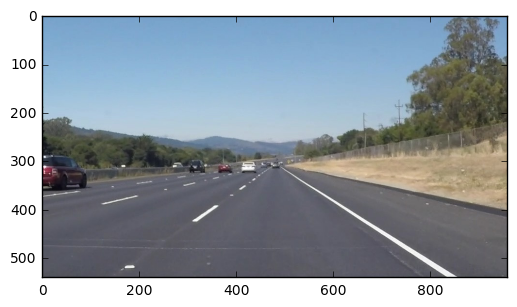

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [11]:
# grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# canny detection for gradient
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# gaussian blur 
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# extract region of interest based on the given vertices
def region_of_interest(img, vertices):
    # get zero image for later drawing lines
    mask = np.zeros_like(img)
    
    if (len(img.shape) > 2):
        channel_count = img.shape[2]
        mask_color = (255, ) * channel_count
    else:
        mask_color = 255
        
    # fill the image with mask based on the vertices
    cv2.fillPoly(mask, vertices, mask_color)
    mask_image = cv2.bitwise_and(mask, img)
    return mask_image

# draw lines based on the result of hough transform
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    if (len(img.shape) == 2):
        img = np.dstack((img, img, img))
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 >= 0 and x1 < img.shape[1] and \
            y1 >= 0 and y1 < img.shape[0] and \
            x2 >= 0 and x2 < img.shape[1] and \
            y2 >= 0 and y2 < img.shape[0]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# hough transform line generation
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros(img.shape, dtype = np.unit8)
    draw_lines(line_img, lines)
    return line_img

# weighted image by simply adding two image
def weighted_img(img, initial_img, alpha = 0.8, beta = 1., lamda = 0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, lamda)

            
        
        
        
        
        
        
        
        
        
        

## Pipeline implementation
In this cell, we implement the image processing pipeline, taking as input the original image and output an annotated image, i.e. the original image with the detected lines drawn on top.

In [64]:
# transform into HSV color space
def rgb_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def show_img(img):
    if len(img) > 2:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = 'gray')
        
def preprocess(img):
    hsv = rgb_to_hsv(img)
    v= hsv[:,:,2]
    kernel_size = 5
    out = gaussian_blur(v, kernel_size)
    return out

def apply_canny(img):
    low_threshold = 50
    high_threshold = 150
    
    out_img = canny(img, low_threshold, high_threshold)
    return out_img

def select_region_interest(img):
    h = 20
    k = 1.75
    v1 = (h, img.shape[0])
    v2 = (img.shape[1]/2 - 5, img.shape[0] / k)
    v3 = (img.shape[1]/2 + 5, img.shape[0] / k)
    v4 = (img.shape[1] - h, img.shape[0])
    return region_of_interest(img, np.array([[v1, v2, v3, v4]], dtype = np.int32))

def extract_edges(img):
    img_canny = apply_canny(img)
    return select_region_interest(img_canny)

def detect_lines(img_canny_masked):
    rho = 2
    theta = np.pi/180
    threshold = 60
    min_line_length = 120
    max_line_gap = 100
    lines = cv2.HoughLinesP(img_canny_masked, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    return lines

def fit_line(line_points):
    x1 = line_points[0]
    y1 = line_points[1]
    x2 = line_points[2]
    y2 = line_points[3]
    
    m = (y2 - y1)/(x2 - x1)
    b = y1 - m * x1
    
    return (m, b)

def extract_lane(img_shape, lines):
    slope_min = 0.5
    slope_max = 2.0
    
    m1 = np.array([])
    b1 = np.array([])
    
    m2 = np.array([])
    b2 = np.array([])
    
    y_min = img_shape[0]
    
    for line_points in lines:
        (m ,b) = fit_line(line_points)
        
        # apply the gradient filter to filter out some bad lines
        if abs(m) > slope_min and abs(m) < slope_max:
            y_min = min(y_min, line_points[1])
            y_min = min(y_min, line_points[3])
            
            # seperate the lines by the sign of gradient
            if (m > 0):
                m1 = np.append(m1, m)
                b1 = np.append(b1, b)
                
            else:
                m2 = np.append(m2, m)
                b2 = np.append(b2, b)
    
    # average the two main lines
    m1 = np.mean(m1)
    b1 = np.mean(b1)
    
    m2 = np.mean(m2)
    b2 = np.mean(b2)
    
    # compute the cross point of the two lines
    x_cross = (b2 - b1)/(m2 - m1)
    y_cross = m1 * x_cross + b1
    
    # end point of line, it is possible that no cross point
    y_end = max(y_cross, y_min)
    
    # compute the coordinate where line cross the bottom edge
    y1 = img_shape[0] - 1
    x1 = (y1 - b1) / m1
    y2 = img_shape[0] - 1
    x2 = (img_shape[0] - b2) / m2
    
    x_end1 = (y_end - b1) / m1
    x_end2 = (y_end - b2) / m2
    
    return np.array([[[x1, y1, x_end1, y_end]], [[x2, y2, x_end2, y_end]]]).astype(int)
    
    
def overlay_lane(img, lane):    
    img_lines = np.copy(img) * 0
    draw_lines(img_lines, lane, color = [255, 0, 0], thickness = 10)
    
    # blend the original image with the previous one
    img_out = weighted_img(img_lines, img)
    return img_out

def pipeline(img_original):
    img = preprocess(img_original)
    
    img_edges = extract_edges(img)
    
    lines = detect_lines(img_edges)
    img_lines = np.copy(img_original)
    draw_lines(img_lines, lines)
    
    lane_para = extract_lane(img.shape, lines.squeeze())
    
    img_out = overlay_lane(img_original, lane_para)
    return img_out
    
    

    
    
    
    


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [39]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

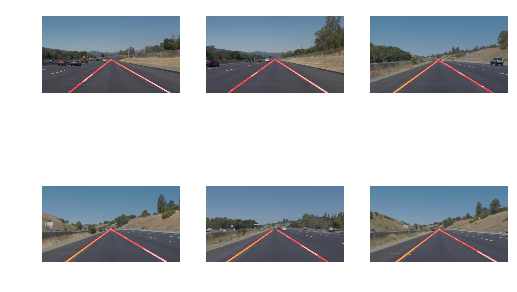

In [65]:
test_images = os.listdir("test_images/")

if not os.path.isdir("results"):
    os.mkdir("results")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    
    # Run the pipeline
    img_out = pipeline(img)
    # Save output
    mpimg.imsave(os.path.join("results", test_images[i]), img_out) 

count = 1
for i in test_images:
    image = mpimg.imread('results/' + i)
    plt.subplot(2, 3, count)
    count = count + 1
    plt.imshow(image)
    plt.axis('off')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [68]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 28.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.89 s, sys: 1.15 s, total: 6.04 s
Wall time: 9.56 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))